In [1]:
# import libraries
import math

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core import KoopDNN,KoopmanNet,KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from core.adapt_net import AdaptNet


from dynamics.duffing import dynamics_duff_data_gen, dynamics_duff



In [2]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 500 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 500 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [3]:
# Oscillator parameters
dyn_pars = {}

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5
dyn_pars['e'] = 1

dyn_pars['del_a'] = 2
dyn_pars['del_b'] = 6
dyn_pars['del_c'] = 1
dyn_pars['del_d'] = 1
dyn_pars['del_e'] = 2
dyn_pars['delay'] = False
dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'sinusoidal'

In [4]:
X_changed, X_unchanged, U = dynamics_duff_data_gen(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_changed.shape, U.shape)

(625, 501, 2) (625, 500, 1)


In [5]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [6]:
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.2736846627067501


In [7]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  2.9725949351119683


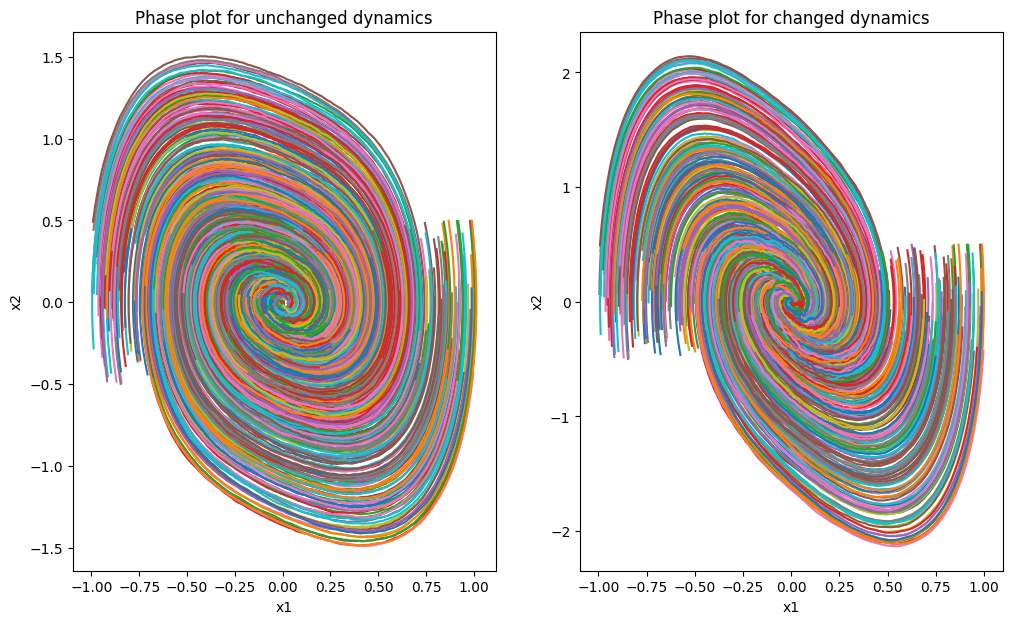

In [8]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])
plt.savefig('phase_plot_duffing.jpg')

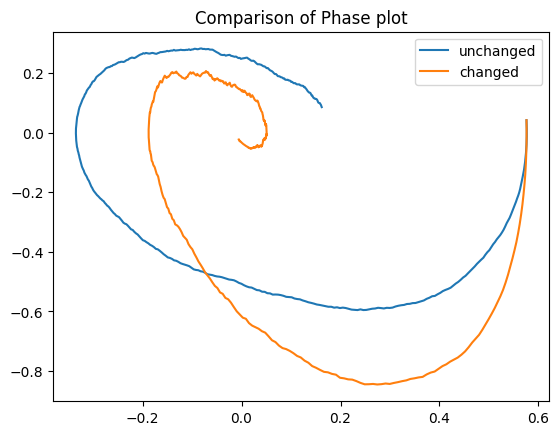

In [9]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.savefig('phase_plot_duffing_single_traj.jpg')
plt.show()


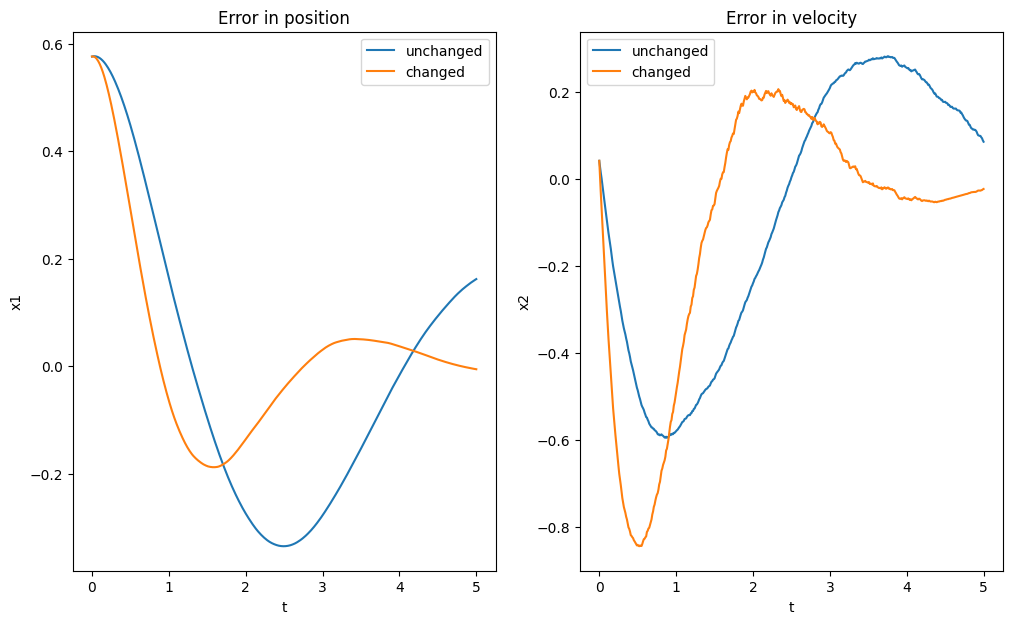

In [10]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

plt.savefig('vel_pos_err_duffing_single_traj.jpg')

In [11]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

***Koopman bilinear Models***

In [12]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 2e-4 # 5e-4
net_params['epochs'] = 200
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [13]:
train = False

if train == True:
    file = 'models/learned_models/bilinear_model/duff_0_01_dim10.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'models/learned_models/bilinear_model/duff_0_01_dim10.pth'
    model_koop_dnn = torch.load(file)

In [14]:
torch.save(model_koop_dnn,file)

In [15]:
# train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
# train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
# train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
# val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
# val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
# val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
# epochs = np.arange(0, net_params['epochs'])
#
# plt.figure(figsize=(15,8))
# plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
# plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
# plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
# plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
# plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
# plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [16]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(13, 13) (13, 13) (2, 13)


In [17]:
# # SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io
#
# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})
#
# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})
#
# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

## Lifting function

# Testing

## Parameters

In [18]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## Testing Data

In [19]:
x_changed_test, x_unchanged_test, u_test = dynamics_duff_data_gen(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(2.0276e-05)


In [20]:
x_unchanged_test.shape

(1, 2001, 2)

In [21]:
# Use the preprocessing if available
X_unchanged,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [22]:
X_changed.shape

(2000, 5)

In [23]:
# flatten vector
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(2000, 2) (2000, 1) (2000, 2)


# Lifting of states

In [24]:
# initialize states
# initialize the matricies
z_unchanged = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_unchanged_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values

In [25]:
x_unchanged[0,:].shape

(2,)

In [26]:
# actual lift
z_unchanged[0,:] = lift(x_unchanged[0,:],model_koop_dnn, net_params)
x_unchanged_est[0,:] = x_unchanged[0,:]

# Time Evolution

In [27]:
for i in range(num_snaps_test):
  #bilinear
    z_unchanged[i+1,:] = np.matmul(z_unchanged[i,:],A.T)+np.matmul(np.kron(u[i,:],z_unchanged[i,:]),B.T)
    x_unchanged_est[i+1,:] = np.matmul(z_unchanged[i+1,:],C.T)

# Plotting

## Lifting performance

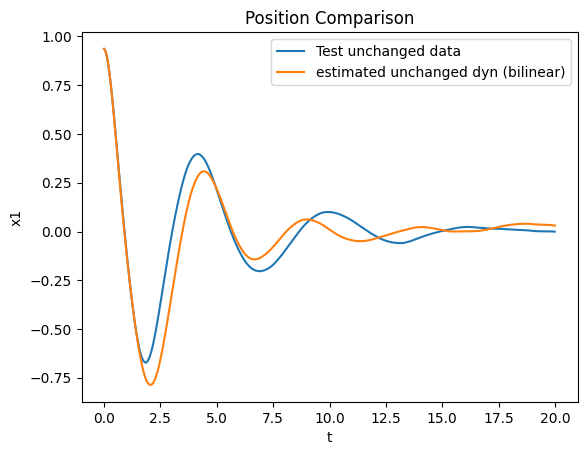

In [28]:
plt.figure()
plt.plot(T_test[:-1], x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test, x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

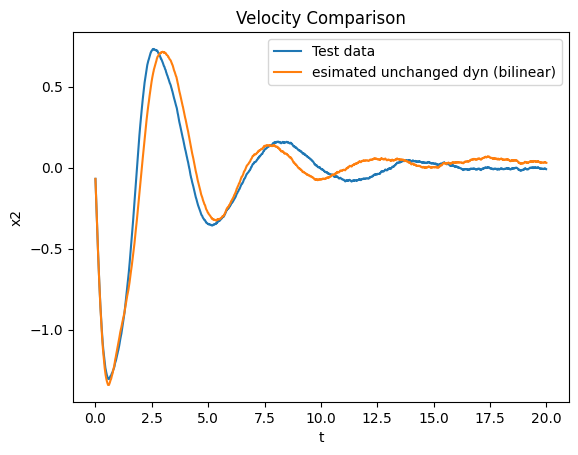

In [29]:
plt.figure()
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

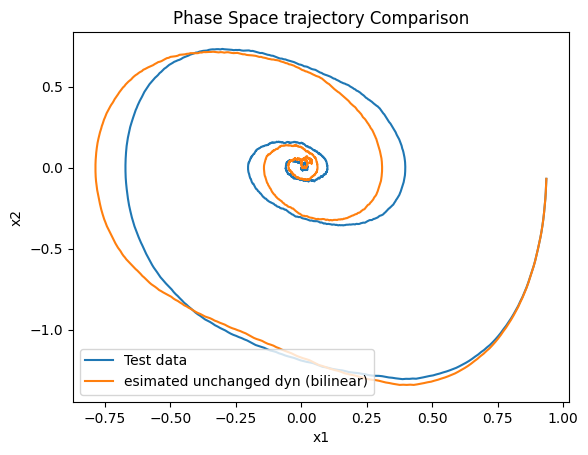

In [30]:
plt.figure()
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [31]:
error_model = np.linalg.norm((x_unchanged_est[:-1,:]-x_unchanged[:,:]),axis=1)
error_dynamics_no_adapt = np.linalg.norm((x_changed[:,:]-x_unchanged[:,:]),axis=1)

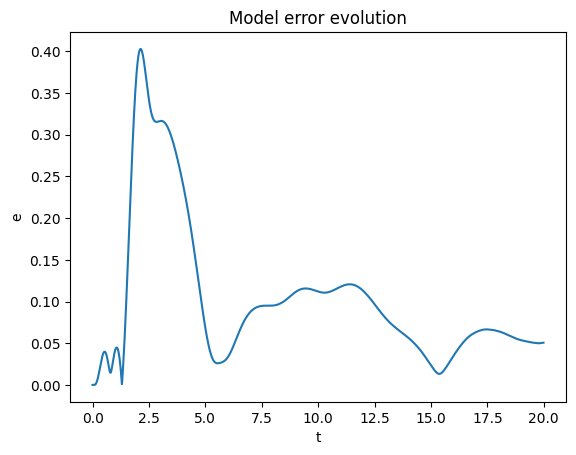

In [32]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Deviation from Actual Dynamics

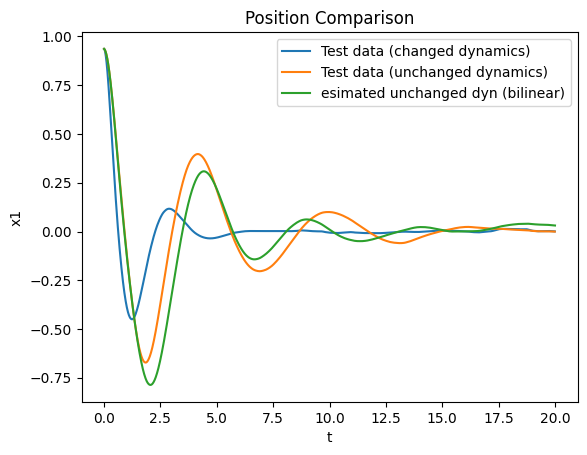

In [33]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,0],label ='Test data (changed dynamics)')
plt.plot(T_test[:-1],x_unchanged[:,0],label ='Test data (unchanged dynamics)')
plt.plot(T_test,x_unchanged_est[:,0],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

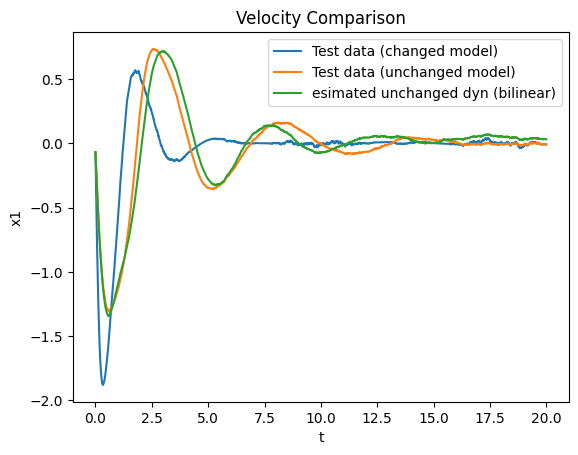

In [34]:
plt.figure()
plt.plot(T_test[:-1],x_changed[:,1],label ='Test data (changed model)')
plt.plot(T_test[:-1],x_unchanged[:,1],label ='Test data (unchanged model)')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

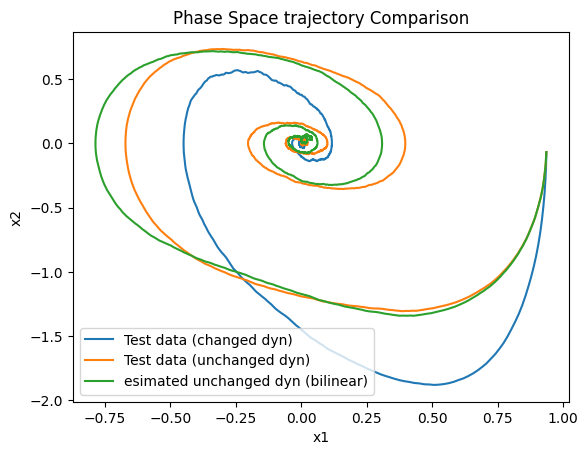

In [35]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data (changed dyn)')
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data (unchanged dyn)')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

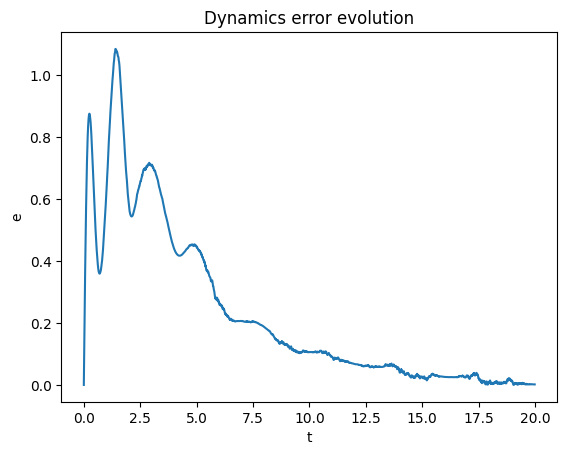

In [36]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

# Adaptation

## Data Preprocessing

# Adaptive Time evolution

In [37]:
adap_window = 3 #hyperparameter

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 5e-4 # 5e-4
adapt_net_params['epochs'] = 8
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 5e-1
adapt_net_params['l1_reg'] = 5e-1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

In [38]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.bilinear_dynamics import bilinear_Dynamics
import scipy

In [39]:
bilinear_model_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
bilinear_model_no_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)

In [40]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [41]:
#Closed loop performance evaluation parameters:
traj_length = 1000
max_iter = 2000
N = 20 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = 100*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc = 0.5*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = 1*np.array([0, 1])                   # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
xmax = 5*np.array([1, 1])                          # State constraints, trajectory generation
xmin = -xmax
umax = 20*np.array([1])
umin = -umax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [42]:
x_ref = np.empty((num_states,traj_length+1))
for i in range(traj_length+1):
    x_ref[:,i] = np.array([np.sin(2*i*dt), 2*np.cos(2*i*dt)])

In [43]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)


In [44]:
# initialize state matricies
u = np.empty((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:]  = xt[0,:]


In [45]:
#controller that works on adapting model
controller_nmpc_adapt = NonlinearMPCController(bilinear_model_adapt, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [46]:
from dynamics.learned_models_control.duff_adapt import Duff_adapt

In [47]:

for i in range(traj_length):
  # incorrect dynamics
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        ZU_old = zu_old_dyn[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet(adapt_net_params)
        adapt_network.model_pipeline(Z_old, ZU_old, del_Z_prime, print_epoch = True)
        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    bilinear_model_adapt.A = scipy.sparse.csc_matrix(bilinear_model_adapt.A.toarray() + del_A)
    bilinear_model_adapt.B = scipy.sparse.csc_matrix(bilinear_model_adapt.B.toarray() + del_B)

    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], zt_old_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)

    _, x_new_dyn[i+1,:] = Duff_adapt(dt, xt[i,:], u[i,:], num_states, dyn_pars)

In [48]:
#controller that works on old model (unadapted)
N_noadapt = 20 #length of horizon
Q_mpc_noadapt = 100*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 4*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
xmax_noadapt = 5*np.array([1, 1])                          # State constraints, trajectory generation
xmin_noadapt = -xmax
umax_noadapt = 20*np.array([1])
umin_noadapt = -umax

In [49]:
controller_nmpc_noadapt = NonlinearMPCController(bilinear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)


In [50]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

for i in range(traj_length):
    # incorrect dynamics
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:]

    # adapted model
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)

    _, x_new_noadapt[i+1,:] = Duff_adapt(dt, xt_no_adapt[i,:], u_no_adapt[i,:], num_states, dyn_pars)

# Performance Plotting

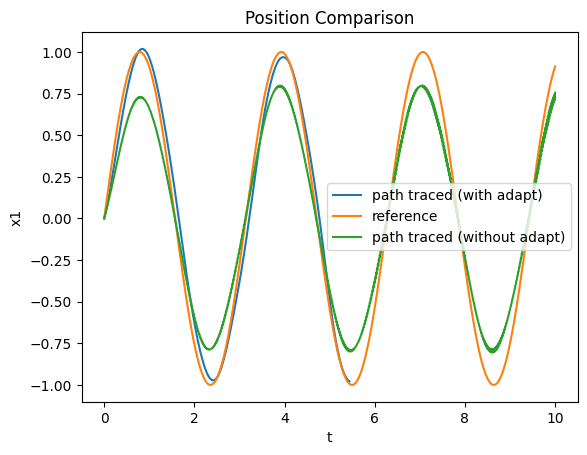

In [51]:
plt.figure()
plt.plot(t_eval, xt[:,0],label ='path traced (with adapt)')
plt.plot(t_eval, x_ref[0,:], label="reference")
plt.plot(t_eval, xt_no_adapt[:,0], label='path traced (without adapt)')
# plt.plot(T_test,x_adap_est[:,0],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_pos.pdf')
plt.show()

In [52]:
i

999

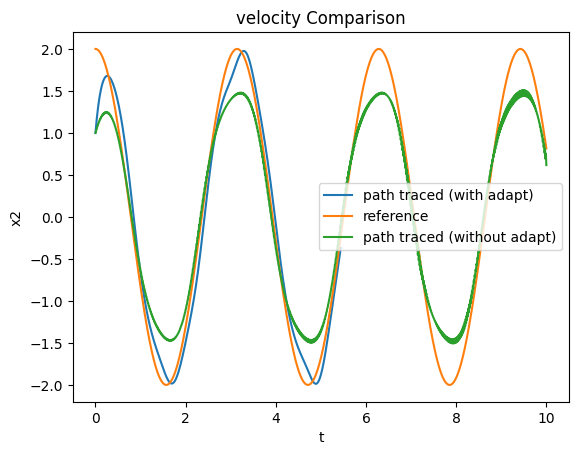

In [53]:
plt.figure()
plt.plot(t_eval, xt[:,1],label ='path traced (with adapt)')
plt.plot(t_eval, x_ref[1,:], label="reference")
plt.plot(t_eval, xt_no_adapt[:,1], label='path traced (without adapt)')
# plt.plot(T_test,x_adap_est[:,0],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('velocity Comparison')
plt.legend()
plt.savefig('vel_plot.pdf')
plt.show()

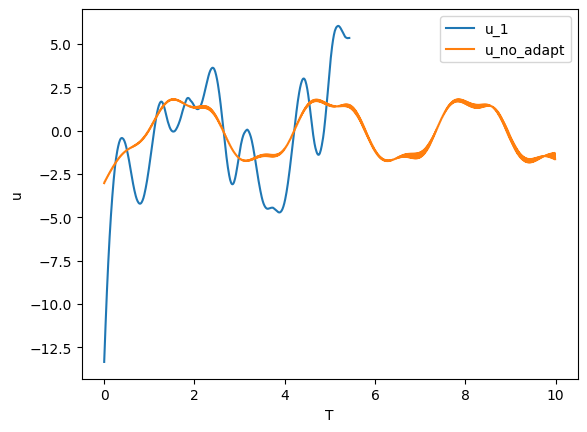

In [54]:
plt.figure()
plt.plot(t_eval[0:-1], u,label ='u_1')
plt.plot(t_eval[0:-1], u_no_adapt,label ='u_no_adapt')
plt.xlabel('T')
plt.ylabel("u")
plt.legend()
plt.savefig('control.pdf')
plt.savefig('controls.pdf')
plt.show()

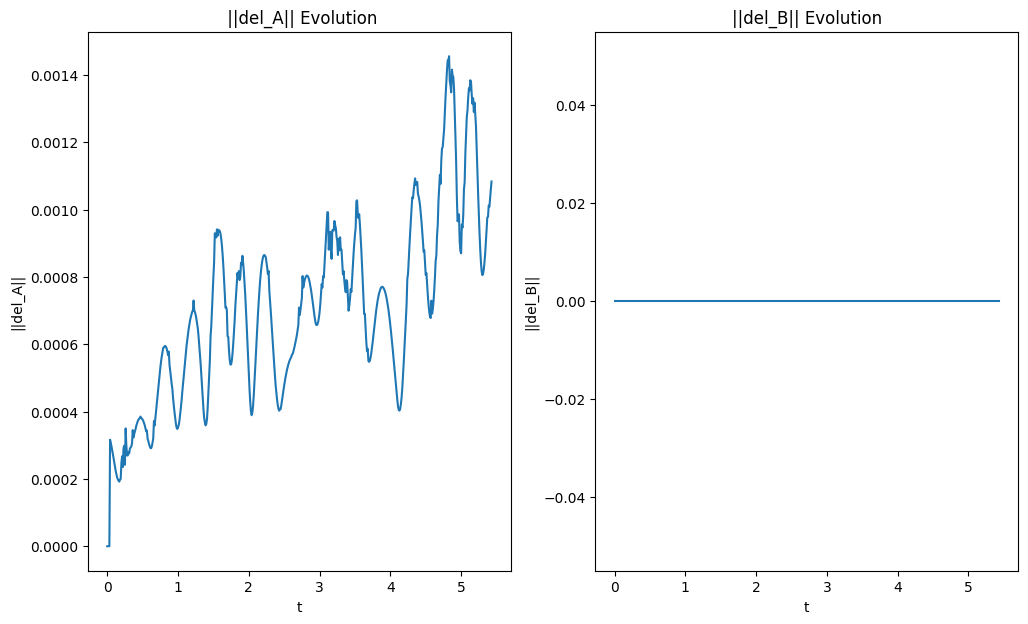

In [55]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(t_eval[:-1],del_A_norm)

axs[1].plot(t_eval[:-1],del_B_norm)
plt.savefig('norms.pdf')
plt.show()

# Error Comparisons

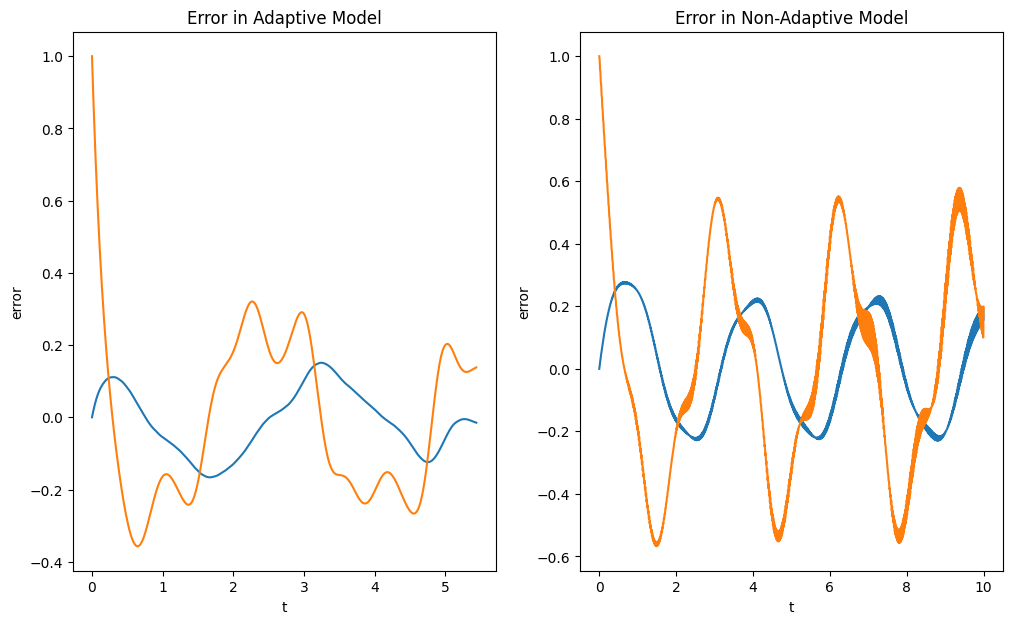

In [56]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')
error_dynamics_adap = x_ref.T - xt
error_dynamics_no_adapt = x_ref.T - xt_no_adapt

axs[0].plot(t_eval,error_dynamics_adap)

axs[1].plot(t_eval,error_dynamics_no_adapt)

plt.savefig('adap_error_comp.pdf')